In [5]:
import pandas as pd
import numpy as np
import random
from hmmlearn import hmm
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

random.seed(4242)

#UPDATE PATH!
temporal = pd.read_csv("D:/OneDrive/Online/SelfLearn/Ryerson/MSc/PaperReplication/temporal_activity.csv", 
                       names = ["bugID", "timeStamp", "activity", "cumDays"])
activity = pd.read_csv("D:/OneDrive/Online/SelfLearn/Ryerson/MSc/PaperReplication/activity_description.csv", 
                      names = ["short", "description"])

# Identify short/fast days based on paper's definition
days = temporal.loc[:,['bugID', 'cumDays']].groupby(by='bugID').max()
days['isSlow'] = np.where(days.cumDays > 60, 1, 0)
# Provide a number for each activity
activity['code'] = activity.index 
temporal = pd.merge(temporal, activity, left_on='activity', right_on='short')
temporal = temporal.iloc[:,[0,1,2,3,6]]
temporal = temporal.sort_values(by=['bugID', 'timeStamp']).reset_index(drop=True)
# Insert isSlow flag
temporal = pd.merge(temporal, days.iloc[:,[1]], left_on='bugID', right_index=True)

temporal = temporal[temporal.activity != 'Z'] # Remove Zs - As observed in Mayy's code
zeroChans = days[days.cumDays == 0].index.values # identify zero day bugs
openMask = temporal.activity.isin(['N', 'M', 'E']) # only include channels that are opened at a certain time

In [6]:
iterCount = 5
activities = 4
initCount = 30
numStates = 5
outputCount = len(np.unique(temporal.activity.values))
# only include channels which are not known to be slow cases when we check first N activities (EX: N <= 4)
arthurCondition = True 
results = pd.DataFrame(columns=['Year', 'Precision', 'Recall', 'F-Score', 'Accuracy'])

for i in range(8):
    year = 2007 + i
    print("Working on {0}".format(year))
    trainChans = temporal[(openMask) & (temporal.timeStamp >= (str(year-1))) & (temporal.timeStamp < (str(year))) & 
                  (~temporal.bugID.isin(zeroChans))].bugID.drop_duplicates().reset_index(drop=True)
    train = temporal[(temporal.timeStamp >= (str(year-1))) & (temporal.timeStamp < (str(year))) & 
                  (temporal.bugID.isin(trainChans))].reset_index(drop=True)
    
    testChans = temporal[(openMask) & (temporal.timeStamp >= (str(year))) & (temporal.timeStamp < (str(year+1))) & 
                  (~temporal.bugID.isin(zeroChans))].bugID.drop_duplicates().reset_index(drop=True)
    test = temporal[(temporal.timeStamp >= (str(year))) & (temporal.timeStamp < (str(year+1))) & 
                  (temporal.bugID.isin(testChans))].reset_index(drop=True)
    
    if arthurCondition:
        # last activity of the first N activities
        lastActivity = test.groupby('bugID').head(activities).groupby('bugID').tail(1)
        # only use series that have not exceeded 60 days because we don't know if it is slow or fast
        fateUnknownMask = np.unique(lastActivity[lastActivity.cumDays <= 60].bugID.values)
        testChans = testChans[testChans.isin(fateUnknownMask)].reset_index(drop=True)
        test = test[test.bugID.isin(fateUnknownMask)].reset_index(drop=True)
    
    # Divide training set based on the flag
    X1 = train[train.isSlow == 1].code.values.reshape(-1,1)
    X2 = train[train.isSlow == 0].code.values.reshape(-1,1)
    lengths1 = train[train.isSlow == 1].groupby(['bugID']).count().code.tolist()
    lengths2 = train[train.isSlow == 0].groupby(['bugID']).count().code.tolist()
    
    if year == 2012:
        X2 = np.append(X2, [10]).reshape(-1,1)
        lengths2.append(1)
    elif year == 2014:
        X2 = np.append(X2, [2])
        X2 = np.append(X2, [9]).reshape(-1,1)
        lengths2.append(1)
        lengths2.append(1)
    
    for j in range(initCount):
        if j % 8 == 0:
            print("{0}th iteration".format(j))
        # Random initlizations for HMM parameters
        emissionprob = np.random.randint(low=1, high = 2000, size=(numStates,outputCount))
        emissionprob = emissionprob/emissionprob.sum(axis=1, keepdims=True)

        transmat = np.random.randint(low=1, high = 2000, size=(numStates,numStates))
        transmat = transmat/transmat.sum(axis=1, keepdims=True)
        
        startprob = np.random.randint(low=1, high = 2000, size=numStates)
        startprob = startprob/startprob.sum(keepdims=True)
        
        slowModel = hmm.MultinomialHMM(n_components  = numStates, n_iter = iterCount)
        slowModel.startprob_ = startprob
        slowModel.transmat_ = transmat
        slowModel.emissionprob_ = emissionprob
        slowModel = slowModel.fit(X = X1, lengths = lengths1)
        
        fastModel = hmm.MultinomialHMM(n_components  = numStates, n_iter = iterCount)
        fastModel.startprob_ = startprob
        fastModel.transmat_ = transmat
        fastModel.emissionprob_ = emissionprob
        fastModel = fastModel.fit(X = X2, lengths = lengths2)
    
        prediction = test.copy()
        prediction.loc[:,'pred'] = pd.Series(np.repeat(-1, test.shape[0]), index=test.index)
        prediction = prediction.loc[:,['bugID','isSlow', 'pred']].drop_duplicates().reset_index(drop=True)

        # Classify bug based on the highest log lilelihood
        for i in range(testChans.shape[0]):
            temp = test[test.loc[:,'bugID'] == testChans.iloc[i]].code.values.reshape(-1,1)[0:activities]
            prediction.iloc[i,2] = np.where(slowModel.score(X = temp) > fastModel.score(X = temp), 1, 0)
        
        precision, recall, fscore, _  = precision_recall_fscore_support(y_true = prediction.isSlow.values,
                                                                y_pred = prediction.pred.values)
        accuracy = accuracy_score(y_true = prediction.isSlow.values,  y_pred = prediction.pred.values)

        temp = pd.DataFrame([[int(year), precision[1], recall[1], fscore[1], accuracy]], 
                 columns=['Year', 'Precision', 'Recall', 'F-Score', 'Accuracy'])
        results= results.append(temp)

Working on 2007
0th iteration
8th iteration
16th iteration
24th iteration
Working on 2008
0th iteration
8th iteration
16th iteration
24th iteration
Working on 2009
0th iteration
8th iteration
16th iteration
24th iteration
Working on 2010
0th iteration
8th iteration
16th iteration
24th iteration
Working on 2011
0th iteration
8th iteration
16th iteration
24th iteration
Working on 2012
0th iteration
8th iteration
16th iteration
24th iteration
Working on 2013
0th iteration
8th iteration
16th iteration
24th iteration
Working on 2014
0th iteration
8th iteration
16th iteration
24th iteration


In [7]:
cleanResults = results.copy()
cleanResults=cleanResults.set_index('Year')
cleanResults = cleanResults.groupby(cleanResults.index).mean()

cleanResults['Precision'] = pd.Series(["{0:.2f}%".format(val * 100) for val in cleanResults['Precision']], 
                                      index = cleanResults.index)
cleanResults['Recall'] = pd.Series(["{0:.2f}%".format(val * 100) for val in cleanResults['Recall']], 
                                   index = cleanResults.index)
cleanResults['F-Score'] = pd.Series(["{0:.2f}%".format(val * 100) for val in cleanResults['F-Score']], 
                                   index = cleanResults.index)
cleanResults['Accuracy'] = pd.Series(["{0:.2f}%".format(val * 100) for val in cleanResults['Accuracy']], 
                                   index = cleanResults.index)
cleanResults

,Precision,Recall,F-Score,Accuracy
Year,,,,
2007,66.96%,82.53%,73.60%,64.37%
2008,64.48%,87.02%,73.93%,63.02%
2009,64.04%,83.57%,72.22%,61.88%
2010,51.72%,70.57%,59.03%,55.18%
2011,30.87%,63.36%,40.42%,47.04%
2012,16.90%,67.23%,24.24%,48.28%
2013,35.58%,47.25%,34.72%,53.88%
2014,18.70%,78.56%,26.44%,39.59%


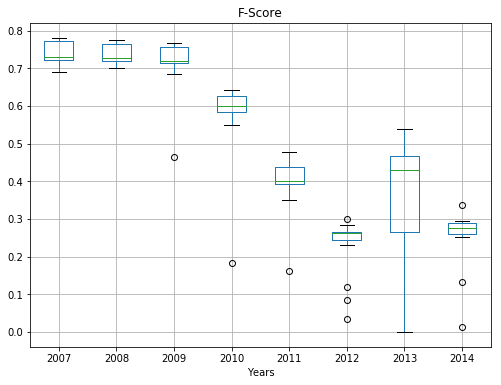

In [12]:
import matplotlib.pyplot as plt

#temp = results[results.index.isin([2007, 2008, 2009])].copy()
results.boxplot(column= ['F-Score'], by = results.Year, vert = True, figsize=(8,6)) 
plt.title("F-Score")
plt.suptitle("")
plt.xlabel('Years')
plt.show()

In [13]:
iterCount = 5
activities = 4
initCount = 30
numStates = 5
outputCount = len(np.unique(temporal.activity.values))

# only include channels which are not known to be slow cases when we check first N activities (EX: N <= 4)
arthurCondition = False 
results2 = pd.DataFrame(columns=['Year', 'Precision', 'Recall', 'F-Score', 'Accuracy'])

for i in range(8):
    year = 2007 + i
    print("Working on {0}".format(year))
    trainChans = temporal[(openMask) & (temporal.timeStamp >= (str(year-1))) & (temporal.timeStamp < (str(year))) & 
                  (~temporal.bugID.isin(zeroChans))].bugID.drop_duplicates().reset_index(drop=True)
    train = temporal[(temporal.timeStamp >= (str(year-1))) & (temporal.timeStamp < (str(year))) & 
                  (temporal.bugID.isin(trainChans))].reset_index(drop=True)
    
    testChans = temporal[(openMask) & (temporal.timeStamp >= (str(year))) & (temporal.timeStamp < (str(year+1))) & 
                  (~temporal.bugID.isin(zeroChans))].bugID.drop_duplicates().reset_index(drop=True)
    test = temporal[(temporal.timeStamp >= (str(year))) & (temporal.timeStamp < (str(year+1))) & 
                  (temporal.bugID.isin(testChans))].reset_index(drop=True)
    
    if arthurCondition:
        # last activity of the first N activities
        lastActivity = test.groupby('bugID').head(activities).groupby('bugID').tail(1)
        # only use series that have not exceeded 60 days because we don't know if it is slow or fast
        fateUnknownMask = np.unique(lastActivity[lastActivity.cumDays <= 60].bugID.values)
        testChans = testChans[testChans.isin(fateUnknownMask)].reset_index(drop=True)
        test = test[test.bugID.isin(fateUnknownMask)].reset_index(drop=True)

    X1 = train[train.isSlow == 1].code.values.reshape(-1,1)
    X2 = train[train.isSlow == 0].code.values.reshape(-1,1)
    lengths1 = train[train.isSlow == 1].groupby(['bugID']).count().code.tolist()
    lengths2 = train[train.isSlow == 0].groupby(['bugID']).count().code.tolist()
    
    if year == 2012:
        X2 = np.append(X2, [10]).reshape(-1,1)
        lengths2.append(1)
    elif year == 2014:
        X2 = np.append(X2, [2])
        X2 = np.append(X2, [9]).reshape(-1,1)
        lengths2.append(1)
        lengths2.append(1)
    
    for j in range(initCount):
        if j % 8 == 0:
            print("{0}th iteration".format(j))
        
        emissionprob = np.random.randint(low=1, high = 2000, size=(numStates,outputCount))
        emissionprob = emissionprob/emissionprob.sum(axis=1, keepdims=True)

        transmat = np.random.randint(low=1, high = 2000, size=(numStates,numStates))
        transmat = transmat/transmat.sum(axis=1, keepdims=True)
        
        startprob = np.random.randint(low=1, high = 2000, size=numStates)
        startprob = startprob/startprob.sum(keepdims=True)
        
        slowModel = hmm.MultinomialHMM(n_components  = numStates, n_iter = iterCount)
        slowModel.startprob_ = startprob
        slowModel.transmat_ = transmat
        slowModel.emissionprob_ = emissionprob
        slowModel = slowModel.fit(X = X1, lengths = lengths1)
        
        fastModel = hmm.MultinomialHMM(n_components  = numStates, n_iter = iterCount)
        fastModel.startprob_ = startprob
        fastModel.transmat_ = transmat
        fastModel.emissionprob_ = emissionprob
        fastModel = fastModel.fit(X = X2, lengths = lengths2)
    
        prediction = test.copy()
        prediction.loc[:,'pred'] = pd.Series(np.repeat(-1, test.shape[0]), index=test.index)
        prediction = prediction.loc[:,['bugID','isSlow', 'pred']].drop_duplicates().reset_index(drop=True)

        for i in range(testChans.shape[0]):
            temp = test[test.loc[:,'bugID'] == testChans.iloc[i]].code.values.reshape(-1,1)[0:activities]
            prediction.iloc[i,2] = np.where(slowModel.score(X = temp) > fastModel.score(X = temp), 1, 0)
        
        precision, recall, fscore, _  = precision_recall_fscore_support(y_true = prediction.isSlow.values,
                                                                y_pred = prediction.pred.values)
        accuracy = accuracy_score(y_true = prediction.isSlow.values,  y_pred = prediction.pred.values)

        temp = pd.DataFrame([[int(year), precision[1], recall[1], fscore[1], accuracy]], 
                 columns=['Year', 'Precision', 'Recall', 'F-Score', 'Accuracy'])
        results2= results2.append(temp)

Working on 2007
0th iteration
8th iteration
16th iteration
24th iteration
Working on 2008
0th iteration
8th iteration
16th iteration
24th iteration
Working on 2009
0th iteration
8th iteration
16th iteration
24th iteration
Working on 2010
0th iteration
8th iteration
16th iteration
24th iteration
Working on 2011
0th iteration
8th iteration
16th iteration
24th iteration
Working on 2012
0th iteration
8th iteration
16th iteration
24th iteration
Working on 2013
0th iteration


C:\Python\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


8th iteration
16th iteration
24th iteration
Working on 2014
0th iteration
8th iteration
16th iteration
24th iteration


In [14]:
cleanResults = results2.copy()
cleanResults=cleanResults.set_index('Year')
cleanResults = cleanResults.groupby(cleanResults.index).mean()

cleanResults['Precision'] = pd.Series(["{0:.2f}%".format(val * 100) for val in cleanResults['Precision']], 
                                      index = cleanResults.index)
cleanResults['Recall'] = pd.Series(["{0:.2f}%".format(val * 100) for val in cleanResults['Recall']], 
                                   index = cleanResults.index)
cleanResults['F-Score'] = pd.Series(["{0:.2f}%".format(val * 100) for val in cleanResults['F-Score']], 
                                   index = cleanResults.index)
cleanResults['Accuracy'] = pd.Series(["{0:.2f}%".format(val * 100) for val in cleanResults['Accuracy']], 
                                   index = cleanResults.index)
cleanResults

,Precision,Recall,F-Score,Accuracy
Year,,,,
2007,70.35%,82.99%,75.90%,66.44%
2008,68.55%,84.97%,75.04%,65.03%
2009,68.28%,84.49%,75.42%,64.87%
2010,63.16%,77.52%,69.39%,61.09%
2011,38.50%,63.05%,47.21%,49.97%
2012,26.24%,64.61%,31.61%,50.80%
2013,44.86%,59.70%,45.55%,53.47%
2014,25.83%,72.41%,33.81%,47.22%


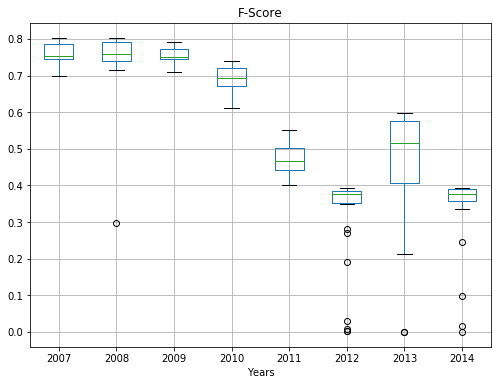

In [15]:
import matplotlib.pyplot as plt

#temp = results2[results2.index.isin([2007, 2008, 2009])].copy()
results2.boxplot(column= ['F-Score'], by = results2.Year, vert = True, figsize=(8,6)) 
plt.title("F-Score")
plt.suptitle("")
plt.xlabel('Years')
plt.show()